# Cellpose Reassign ROIs

Cellpose marks every cell it detects with a ROI number (Region of Interest). However, as the machine learning method is not perfect, we have to relabel each ROI so that the same cell has the same ROI. This helps us in determining the displacement later

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io, utils
from cellpose.io import imread
from pathlib import Path
import os
from PIL import Image

In [3]:
# List of Files
# Importing all the files
basedir = os.path.join(Path.cwd(), "Images")
files = io.get_image_files(basedir, "")

# Makes the directy to point to the seg files
dir = []
filesNames = []
for f in files: 
    a = (os.path.join(basedir, f) + "_seg.npy").replace(".png", "")
    dir.append(a)
    filesNames.append(os.path.basename(os.path.normpath(a)))
dir = dir[0:10] # stores the seg files ignores the first 



In [113]:
def fileNameFromPath(dre): 
    a = (os.path.basename(os.path.normpath(dre)))
    count = 0 
    char = a[0]
    num = ""

    while char != "_": 
        count += 1
        num += char
        char = a[count]
    
    return int(num)

In order to reassign the ROIs we need to get the Outlines of a specific files we are dealing with. For relabelling, I have chosen the first .npy file after segmentation as a reference. First we create a function to get a 


In [4]:
def getOutlines(fileOne, fileTwo, Mask = False): # takes in the directory to the first and second files
    # Import the first oultine

    datOne = np.load(fileOne, allow_pickle=True).item()
    masksOne = datOne['masks']
    outlinesOne = datOne['outlines']

    datTwo = np.load(fileTwo, allow_pickle=True).item()
    masksTwo = datTwo['masks']
    outlinesTwo = datTwo['outlines']
    if Mask == False: 
        return  (outlinesOne, outlinesTwo)
    elif Mask == True: 
        return (masksOne, masksTwo)

Now, we can make a cuntion to get a specific roi from the matrix. As the Matrix is constructed as follows (an example): 

00110220 <br>
01001202 <br>
01110220 <br>
00000000 <br>

The 0 indicates there is no outline there. The number indicates that there is a pixel at that poistion, and the value of the number indicates it's ROI. By filtering out the values of the ROI that we want, we can proceed as we do

In [5]:
# Returns a specific outline given an roi 
def specificOutline(imgarr, roi): # takes in an imagearr and the roi
    empty = np.zeros_like(imgarr) 
    specific = np.where(imgarr == roi, imgarr, empty)
    return specific

def plotSide(a, b): # plots two outlines side by side. Made for convenience
    full, fullarr = plt.subplots(1,2)
    fullarr[0].imshow(a)
    fullarr[1].imshow(b)

In [144]:
# Function to see if the ROI Matches
def checkROI(outA, outB): # input two outlines as matrixes
    row, col = outA.shape
    count = 0
    outCount = 0 
    # We iterate through the entire matrix which represents the two outlines. 
    for i in range(row): 
        for j in range(col):
            if (outA[i][j] != 0):  # Find how many pixels are used to make the outlines
                outCount += 1      # outCount gives the number of pixels to create the outlines
                if outB[i][j] != 0:
                    count +=1      # The number of overlapping pixels in the first and second outlines
    if outCount == 0:
        # print("no overlap:") 
        return False
    elif count/outCount * 100 >= 10: 
        # print("Overlap:", count/outCount * 100 ) # If more that 10% of it overlaps, we say it's the same cell
        return True
    elif count > 0: 
        print("Some Overlap:", count/outCount * 100) 
        return False 
    else: 
        return False

In [185]:
def findNonMatching(directory, lower, upper):
    
    weird = [] # Stores the weird/not working files. Namely the ones that dont' have matching ROIs
    BadOnes = [] # stores how many weird ones there are per frame 

    # Following code gives back a tuple with (index number, number of incorrectly labeled ROIs, an array with the outlines that aren't working)
    for i in range(lower, upper): # start from 1 as 0 doesn't matter
        outlinesFirst, outlinesLast = getOutlines(directory[0],  directory[i])
        weird = []
        
        for out in range(1, np.amax(outlinesLast)): 
            outA = specificOutline(outlinesFirst, out)
            outB = specificOutline(outlinesLast, out)
            check = checkROI(outA, outB)
            if check == False:
                weird.append(out)
            # full, fullarr = plt.subplots(1,2)
            # fullarr[0].imshow(outA)
            # fullarr[1].imshow(outB)
          
        if len(weird) > 0: 
            BadOnes.append((fileNameFromPath(directory[i]), weird))
    return BadOnes

# Bad = findNonMatching(dir, len(dir))


In [109]:
def FixROI(A, B, roi): # Takes in an Array and the outline u want
    # initializing
    sigma = 0 
    count = 0 
    loopNum = 0 

    a = specificOutline(A, roi)
    b = specificOutline(B, roi)

    while (checkROI(a, b) == False) and  (0 < roi + sigma < np.amax(B)):
        sigma = count * (-1)**loopNum  # Lets us check the ROI above and below 
        b = specificOutline(B, roi + sigma)
        if loopNum % 2 != 0: # number is odd
            countFinder = loopNum - 1 
        else: 
            countFinder = loopNum
        count = 0.5 * countFinder + 1
        loopNum += 1
        
    return (roi + sigma)



In [110]:
def evalOne(filename, M): 
    img = imread(filename)
    modeldir = os.path.join(Path.cwd(),"Images","models","Rebirth_2") 
    model = models.CellposeModel(gpu = True, pretrained_model = modeldir)
    masks, flows, styles = model.eval(img, diameter=None, channels=[0,0])
    # save results so you can load in gui
    io.masks_flows_to_seg(img, M, flows, styles, filename, [0,0])


In [10]:
def getROI(Segdir, all = False): # Requires directory to the segmentation.npy files 
    from statistics import mode
    max = []
    for d in Segdir: 
        dat = np.load(d, allow_pickle=True).item()
        max.append(np.amax(dat['masks']))
    if all == False: 
        return mode(max)
    elif all == True: 
        return max

In [186]:
L = findNonMatching(dir, 4, 5)
FileNum, wrongROIs = L[1]
dat = np.load(dir[FileNum], allow_pickle=True).item()
masks = dat['masks']
name = dat['filename']
arr1, arr2 = getOutlines(dir[0], dir[FileNum])

TypeError: findNonMatching() missing 1 required positional argument: 'upper'

In [197]:
L = findNonMatching(dir, 3, 4)
FileNum, wrongROIs = L[0]
arr1, arr2 = getOutlines(dir[0], dir[FileNum])
masks = dat['masks']
name = dat['filename']

print(L[0])

(3, [17, 21, 24, 43])


In [200]:
FixROI(arr1, arr2, 23)

23

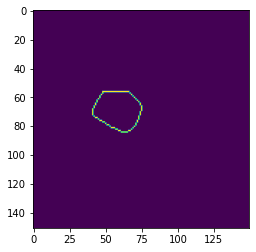

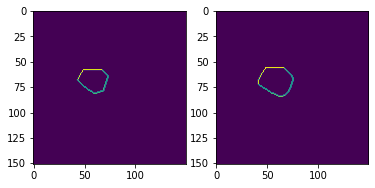

In [133]:
FixROI(arr1, arr2, 17)
plt.imshow(specificOutline(arr2, 17))
checkROI(specificOutline(arr1, 17), specificOutline(arr2, 17))
plotSide(specificOutline(arr1, 17), specificOutline(arr2, 17))